In [1]:
import os

import torch
import torch.nn.functional as F

import segmentation_models_pytorch as smp

import numpy as np
import cv2
import matplotlib.pyplot as plt

from safetensors.torch import load_file

In [2]:
# Paths
ROOT = os.getcwd()
DATA_DIR = os.path.join(ROOT, 'data')
TEST_DIR = os.path.join(DATA_DIR, 'test')
CHECKPOINT_PATH =  os.path.join(ROOT, 'checkpoints', 'unet_segment.safetensors')

# Torch settings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Model
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
).to(DEVICE)

model_state_dict = load_file(CHECKPOINT_PATH)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [4]:
ORIG_SHAPE = (1920, 1080)
RESIZE_SHAPE = (736, 416)

orig_imgs = []
imgs = []
for filename in os.listdir(TEST_DIR):
    img = cv2.imread(os.path.join(TEST_DIR, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img.copy()

    img = cv2.resize(img, ORIG_SHAPE, interpolation=cv2.INTER_CUBIC)   # resize to orig shape
    img = cv2.resize(img, RESIZE_SHAPE, interpolation=cv2.INTER_AREA) # resize to model shape
    img = img.astype(np.float32)
    img /= 255.0

    img = torch.tensor(img, dtype=torch.float32)
    img = torch.permute(img, (2, 0, 1))

    orig_imgs.append(img_copy)
    imgs.append(img.to(DEVICE))

In [5]:
masks = []
with torch.no_grad():
    for img in imgs:
        mask = model(img.unsqueeze(0)).squeeze(0, 1)
        mask = F.sigmoid(mask)
        # mask = (mask > 0.15) # uncomment for binary view
        masks.append(mask.cpu())

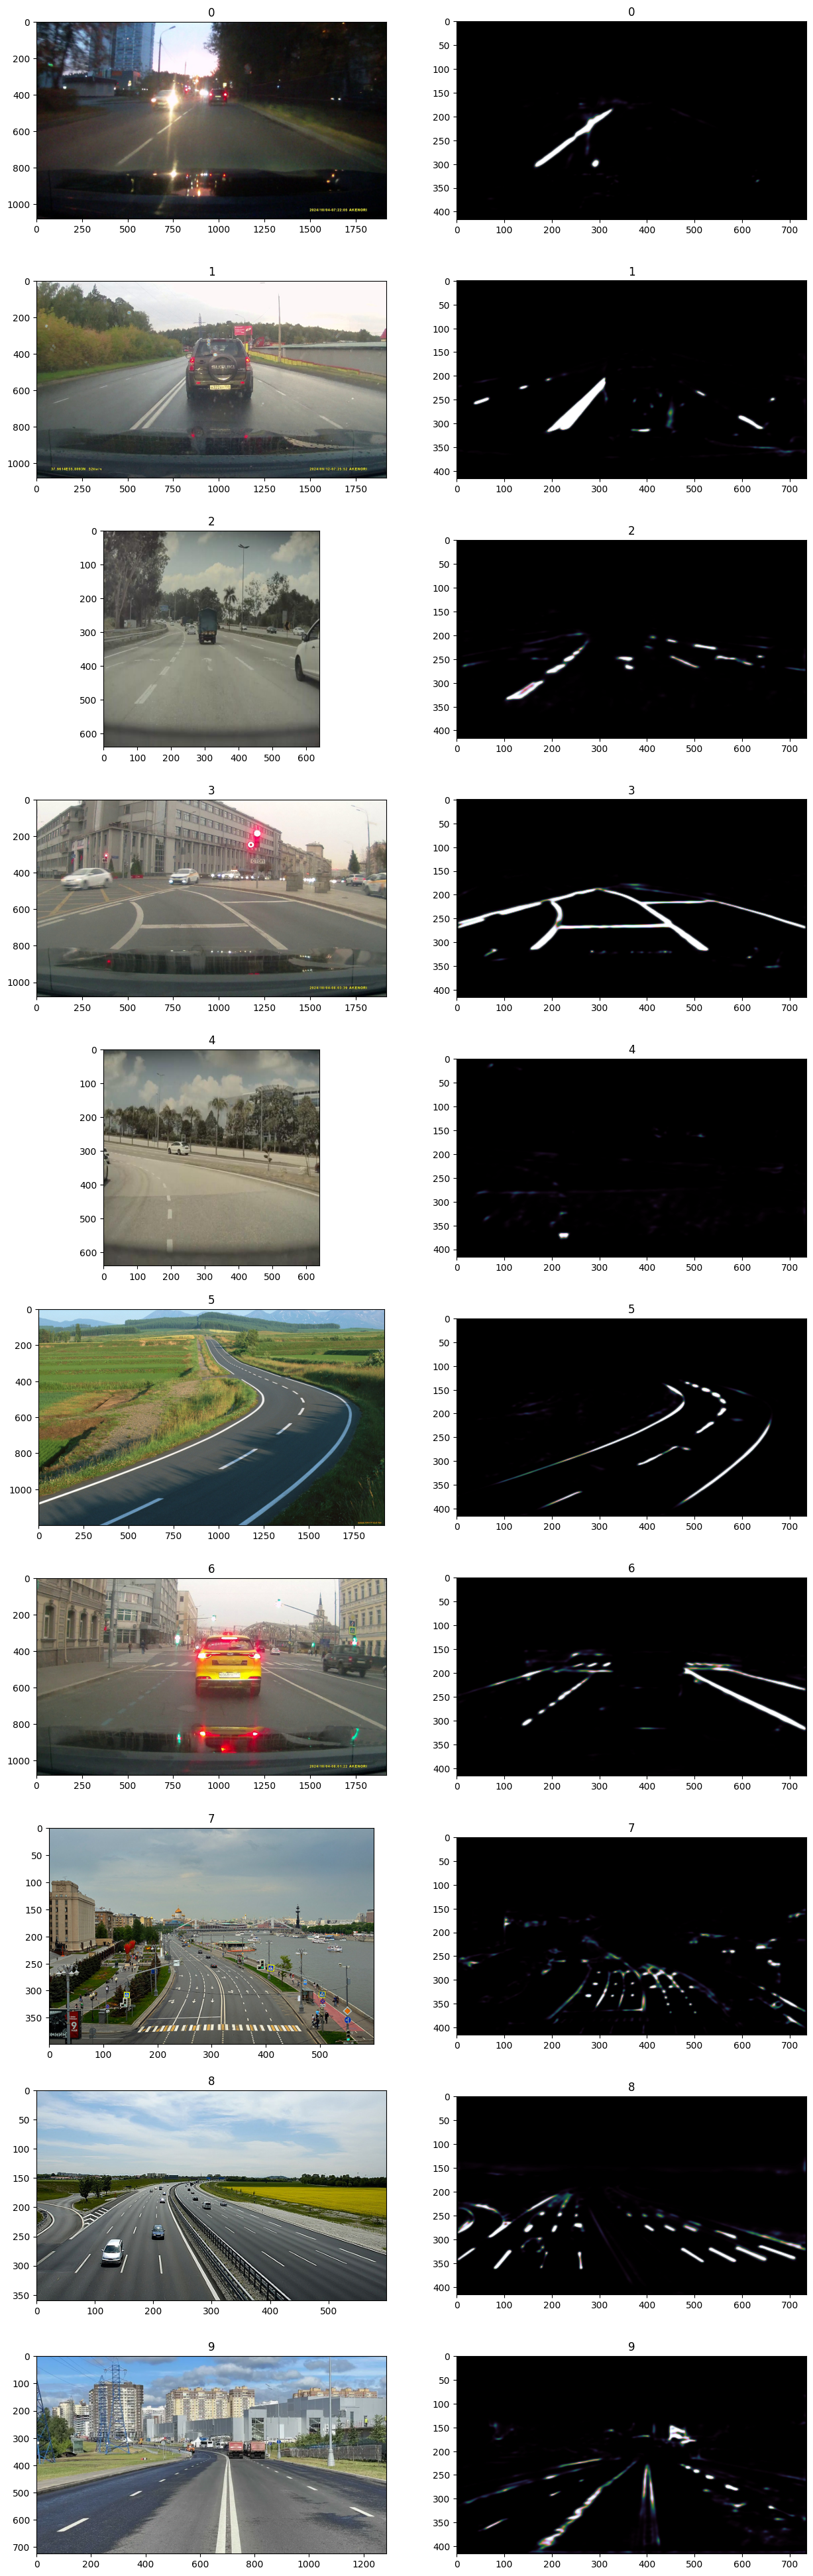

In [6]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15, 50))
for i in range(len(axs)):
    axs[i][0].imshow(orig_imgs[i])
    axs[i][0].set_title(i)
    axs[i][0]

    axs[i][1].imshow(masks[i], cmap='cubehelix')
    axs[i][1].set_title(i)

plt.show()